# LV3 - Klasifikacija teksta pomoću strojnog učenja



## Ciljevi laboratorijske vježbe:


*   Pripremiti označene skupove podataka za klasifikaciju teksta
*   Trenirati klasifikator
*   Evaluirati performanse klasifikatora (točnost, preciznost, odziv)



## 1. Instalacija biblioteka

In [54]:
from google.colab import files
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

## 2. Učitavanje dataseta Coronavirus tweets NLP - Text Classification

Potrebno je preuzeti javni dataset s platforme Kaggle. Kako bi preuzimanje bilo uspješno, potrebno je preuzeti datoteku `kaggle.json` sa svog Kaggle korisničkog profila i uploadati ju prilikom izvođenja sljedećeg programskog koda. Moguće je i preuzeti dataset i prenijeti ga u Google Colab ručno. Dataset možete preuzeti na [linku](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification).



In [55]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification

Dataset URL: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification
License(s): copyright-authors
covid-19-nlp-text-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [56]:
!unzip covid-19-nlp-text-classification.zip -d covid_dataset



Archive:  covid-19-nlp-text-classification.zip
  inflating: covid_dataset/Corona_NLP_test.csv  
  inflating: covid_dataset/Corona_NLP_train.csv  


In [57]:
# Ovaj dataset dolazi kodiran u ISO-8859-1 (Latin-1), pa je potrebno specificirati encoding parametar
train = pd.read_csv("covid_dataset/Corona_NLP_train.csv", encoding="latin1")
test = pd.read_csv("covid_dataset/Corona_NLP_test.csv", encoding="latin1")

train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## 3. Priprema podataka



### a) Odabir značajki

In [58]:
selected_features_train = train[['OriginalTweet', 'Sentiment']]
selected_features_test = test[['OriginalTweet', 'Sentiment']]

### b) Provjera nedostajućih vrijednosti

In [59]:
print(selected_features_train.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_train.isnull().sum()}")

41157
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Budući da stupac Location neće biti korišten pri treniranju modela, nedostajuće vrijednosti se mogu zanemariti.

In [60]:
# ZADATAK: Provjerite nedostajuće vrijednosti u testnom skupu te riješite na prikladan način ukoliko ih ima
print(selected_features_test.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_test.isnull().sum()}")


3798
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64
Sentiment
Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: count, dtype: int64


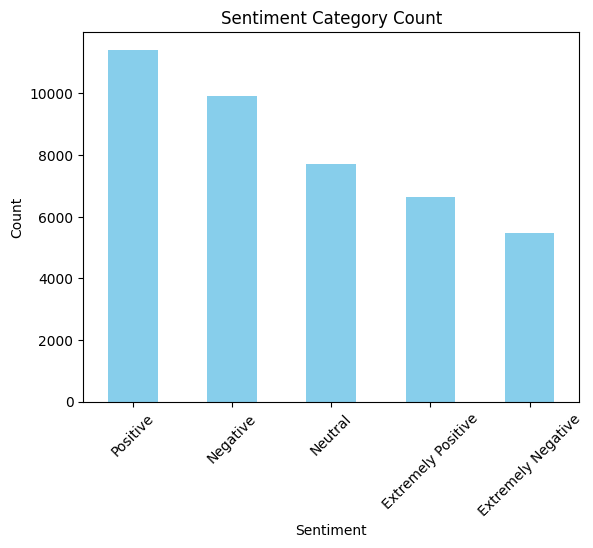

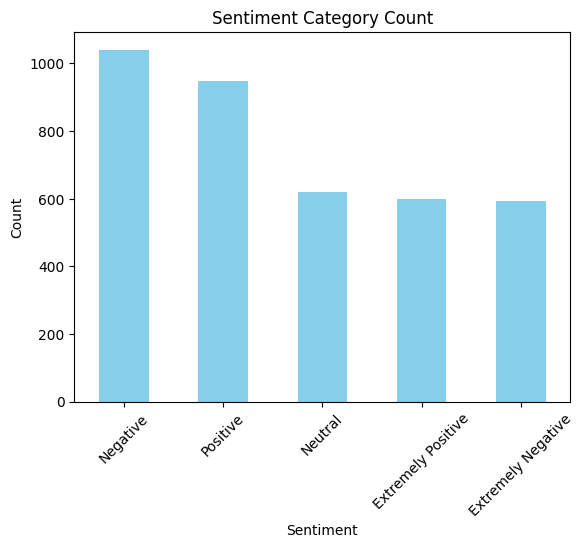

In [61]:
#ZADATAK: Provjerite broj ponavljanja svake od kategorija tweetova te ih prikžite na grafu koristeći prikladne biblioteke

print(selected_features_train['Sentiment'].value_counts())
print(selected_features_test['Sentiment'].value_counts())

selected_features_train['Sentiment'].value_counts().plot(kind='bar', color='skyblue')

plt.title('Sentiment Category Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

selected_features_test['Sentiment'].value_counts().plot(kind='bar', color='skyblue')

plt.title('Sentiment Category Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [62]:
mapping = {
    'Positive': 'Positive',
    'Extremely Positive': 'Positive',
    'Negative': 'Negative',
    'Extremely Negative': 'Negative',
    'Neutral': 'Neutral'
}

selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)

#ZADATAK: Prikažite broj primjeraka u svakoj klasi nakon mapiranja
print(selected_features_train['Sentiment'].value_counts())
print(selected_features_test['Sentiment'].value_counts())

Sentiment
Positive    18046
Negative    15398
Neutral      7713
Name: count, dtype: int64
Sentiment
Negative    1633
Positive    1546
Neutral      619
Name: count, dtype: int64


/tmp/ipython-input-1214061518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
/tmp/ipython-input-1214061518.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)


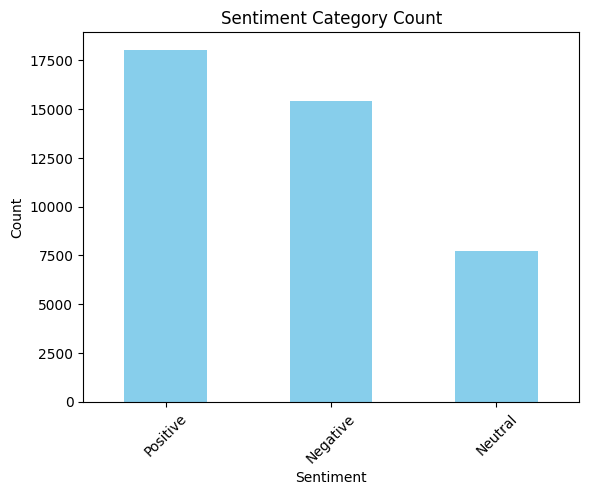

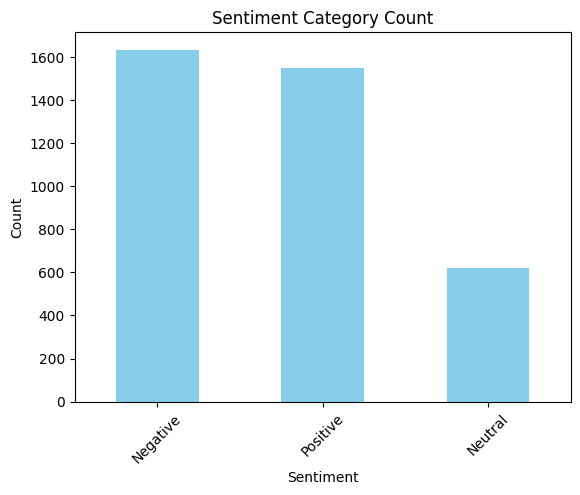

In [63]:
selected_features_train['Sentiment'].value_counts().plot(kind='bar', color='skyblue')

plt.title('Sentiment Category Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

selected_features_test['Sentiment'].value_counts().plot(kind='bar', color='skyblue')

plt.title('Sentiment Category Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### c) Lematizacija i čišćenje teksta

In [128]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [129]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  # ZADATAK: Napišite funkciju za lematizaciju teksta
  tokens = text.split()
  lemmas = [lemmatizer.lemmatize(token) for token in tokens]
  return " ".join(lemmas)


selected_features_train['clean_tweet'] = selected_features_train['OriginalTweet'].apply(lemmatize_text).apply(clean_text)
selected_features_test['clean_tweet'] = selected_features_test['OriginalTweet'].apply(lemmatize_text).apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/tmp/ipython-input-93023093.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_train['clean_tweet'] = selected_features_train['OriginalTweet'].apply(lemmatize_text).apply(clean_text)
/tmp/ipython-input-93023093.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

### d) Pretvaranje teksta u vektore značajki (TF-IDF)

TF-IDF (Term Frequency–Inverse Document Frequency) je statistička metoda koja se koristi u obradi prirodnog jezika i pretraživanju informacija za procjenu koliko je određena riječ važna za jedan dokument u odnosu na veću zbirku dokumenata. TF-IDF kombinira dvije komponente:
1. Frekvencija pojma (TF): Mjeri koliko se puta riječ pojavljuje u dokumentu. Veća učestalost sugerira veću važnost. Ako se neki pojam često pojavljuje u dokumentu, vjerojatno je relevantan za sadržaj tog dokumenta.
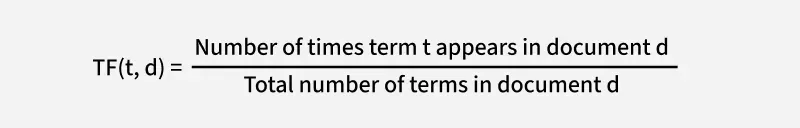

2. Obrnuta frekvencija dokumenta (IDF): Smanjuje težinu uobičajenih riječi koje se pojavljuju u više dokumenata, dok povećava težinu rijetkih riječi. Ako se pojam pojavljuje u manjem broju dokumenata, veća je vjerojatnost da je značajan i specifičan.
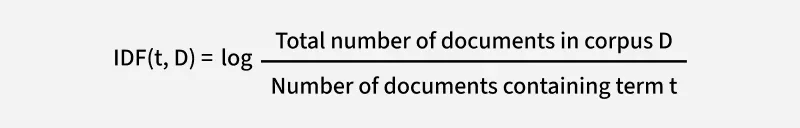

Ova ravnoteža omogućuje TF-IDF-u da istakne pojmove koji su i učestali unutar određenog dokumenta i prepoznatljivi u odnosu na ostatak zbirke dokumenata, što ga čini korisnim alatom za zadatke poput rangiranja pretraživanja, klasifikacije teksta i izdvajanja ključnih riječi.

In [130]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_train = tfidf.fit_transform(selected_features_train['clean_tweet'])
#ZADATAK: Transformirati očišćene tekstualne tweetove u numeričku TF-IDF reprezentaciju na testnom skupu.
X_test = tfidf.transform(selected_features_test['clean_tweet'])

### e) Enkodiranje oznaka

In [131]:
le = LabelEncoder()

print(selected_features_train['Sentiment'].unique())

y_train = le.fit_transform(selected_features_train['Sentiment'])
y_test = le.transform(selected_features_test['Sentiment'])

y_train = pd.DataFrame(y_train, columns=['Sentiment'])
y_test = pd.DataFrame(y_test, columns=['Sentiment'])
y_train.head()

['Neutral' 'Positive' 'Negative']


,Sentiment
0,1
1,2
2,2
3,2
4,0


## 4. Treniranje modela - Naive Bayes

In [132]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best alpha: {'alpha': 0.1}
Best cross-val accuracy: 0.6764586498292324


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [133]:
model = MultinomialNB(alpha = 0.1)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=0.1)

## 5. Evaluacija performansi

In [134]:
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.72      0.72      0.72      1633
     Neutral       0.63      0.20      0.30       619
    Positive       0.63      0.81      0.71      1546

    accuracy                           0.67      3798
   macro avg       0.66      0.57      0.58      3798
weighted avg       0.67      0.67      0.65      3798



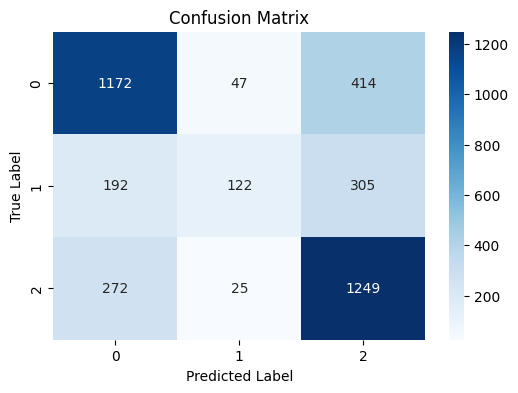

In [135]:
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## ZADATAK:
Trenirati model koristeći SVM i usporediti performanse s Naive Bayes-om.

In [136]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train.values.ravel())

y_pred_svm = svm_model.predict(X_test)

print("Classification Report (SVM):\n")
print(classification_report(y_test, y_pred_svm))

Classification Report (SVM):

              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1633
           1       0.66      0.64      0.65       619
           2       0.80      0.83      0.81      1546

    accuracy                           0.78      3798
   macro avg       0.75      0.75      0.75      3798
weighted avg       0.78      0.78      0.78      3798



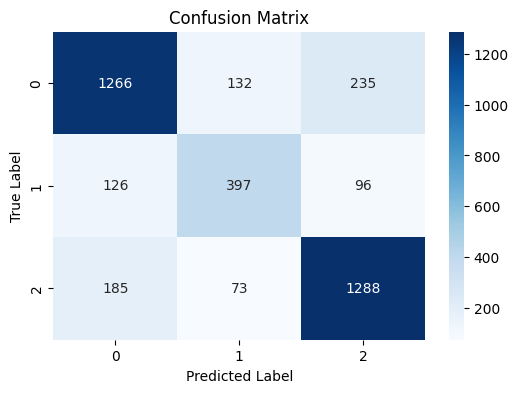

In [137]:
cm = confusion_matrix(y_test, y_pred_svm)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

SVM model postiže bolje rezultate na svim podacima u datasetu

# Zadatak – samostalan rad na datasetu

### U ovom zadatku studenti će sami proći cijeli proces klasifikacije teksta koristeći metode strojnog učenja – od pripreme podataka do treniranja i usporedbe različitih modela.

Cilj je klasificirati opise proizvoda iz e-trgovine u jednu od četiri kategorije (Electronics, Household, Books, Clothing & Accessories).

### Koraci zadatka:

1. **Pregled dataseta**  
   - Preuzmite dataset „E-commerce Text Classification“ s Kaggle-a:  
     https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification  
   - Učitajte ga u Colab (npr. pomoću `pd.read_csv`)  
   - Prikažite osnovne informacije o datasetu

2. **Odabir značajki i čišćenje podataka**  
   - Provjerite i obradite nedostajuće vrijednosti
   - Uklonite duplikate ako postoje  
   - Po potrebi uravnotežite dataset (npr. undersampling/oversampling) – nije obavezno, ali je plus

3. **Predobrada teksta (čišćenje i lematizacija)**  
   - Pretvorite tekst u mala slova  
   - Uklonite HTML tagove, URL-ove, interpunkciju, brojeve, specijalne znakove  
   - Uklonite stop-riječi  
   - Provedite lematizaciju

4. **Pretvaranje teksta u vektore značajki**  
     - `TfidfVectorizer`
   - Podijelite podatke na train/test skup (80/20 ili 75/25)

5. **Enkodiranje oznaka (labela)**  
   - Pretvorite tekstualne kategorije u brojčane pomoću `LabelEncoder` ili `OneHotEncoder` (ovisno o modelu)

6. **Treniranje i usporedba modela**  
   
   
   Za svaki model:
   - Naučite model na trening skupu
   - Izmjerite performanse na test skupu: **accuracy, precision, recall, F1-score**
   - Nacrtajte **confusion matrix** i **classification report**
   - Ako stignete: Podesite hiperparametre (barem `GridSearchCV` ili `RandomizedSearchCV` na 2–3 parametra) za bolje rezultate

7. **Vizualizacija rezultata**  
   - Usporedite dva (ili više) modela u tablici i stupčastim grafom (accuracy, F1-score)
   
   - Ako koristite TF-IDF, pokažite 10–20 riječi s najvećim TF-IDF težinama po klasi (Iz riječi biste trebali zaključiti o kojoj klasi se radi)

8. **Zaključak i komentar rezultata**  
   - Koji model je bio bolji i zašto?
   - Koje su prednosti i nedostaci pristupa koje ste koristili?
   - Što biste još mogli isprobati da poboljšate rezultat (ideje za daljnje eksperimente)?
   - Koliko je predobrada teksta utjecala na performanse?


In [74]:
!kaggle datasets download -d saurabhshahane/ecommerce-text-classification

Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification
License(s): Attribution 4.0 International (CC BY 4.0)
ecommerce-text-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [139]:
dt = pd.read_csv('ecommerce-text-classification.zip', compression='zip', header=None)
dt.columns = ["Categories", "Details"]
dt.head()

,Categories,Details
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [140]:
len(dt)

50425

In [141]:
dt.dropna(inplace=True)

In [142]:
len(dt)

50424

In [143]:
dt.drop_duplicates(inplace=True)

In [144]:
len(dt)

27802

In [145]:
print(dt['Categories'].value_counts())

Categories
Household                 10564
Books                      6256
Clothing & Accessories     5674
Electronics                5308
Name: count, dtype: int64


In [147]:
from imblearn.over_sampling import RandomOverSampler
X = dt.drop('Categories', axis=1)
y = dt['Categories']

ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X, y)

print(y_over.value_counts())

Categories
Household                 10564
Books                     10564
Clothing & Accessories    10564
Electronics               10564
Name: count, dtype: int64


In [148]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [w for w in text.split() if w not in stop_words]
    return ' '.join(tokens)

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


dt['Clean_Details'] = dt['Details'].apply(clean_text).apply(lemmatize)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [152]:
X_train, X_test, y_train, y_test = train_test_split(
    dt['Clean_Details'], dt['Categories'], test_size=0.2, random_state=42, stratify=dt['Categories']
)

In [153]:
#Pretvaranje teksta u vektore značajki
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [154]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [155]:
nb = MultinomialNB(alpha = 0.1)
nb.fit(X_train_tfidf, y_train_enc)
nb_pred = nb.predict(X_test_tfidf)

print(classification_report(y_test_enc, nb_pred, target_names=le.classes_))
print(confusion_matrix(y_test_enc, nb_pred))
nb_acc = accuracy_score(y_test_enc, nb_pred)

                        precision    recall  f1-score   support

                 Books       0.97      0.89      0.93      1251
Clothing & Accessories       0.95      0.97      0.96      1135
           Electronics       0.91      0.92      0.92      1062
             Household       0.92      0.95      0.93      2113

              accuracy                           0.94      5561
             macro avg       0.94      0.93      0.94      5561
          weighted avg       0.94      0.94      0.94      5561

[[1114   24   25   88]
 [   3 1104    4   24]
 [  12    3  978   69]
 [  18   27   63 2005]]


In [156]:
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train_enc)
svm_pred = svm.predict(X_test_tfidf)

print(classification_report(y_test_enc, svm_pred, target_names=le.classes_))
print(confusion_matrix(y_test_enc, svm_pred))
svm_acc = accuracy_score(y_test_enc, svm_pred)

                        precision    recall  f1-score   support

                 Books       0.96      0.94      0.95      1251
Clothing & Accessories       0.98      0.98      0.98      1135
           Electronics       0.95      0.93      0.94      1062
             Household       0.95      0.97      0.96      2113

              accuracy                           0.96      5561
             macro avg       0.96      0.95      0.96      5561
          weighted avg       0.96      0.96      0.96      5561

[[1174    9   22   46]
 [   5 1114    2   14]
 [  17    6  985   54]
 [  32   10   29 2042]]


In [157]:
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'SVM'],
    'Accuracy': [nb_acc, svm_acc]
})
results


,Model,Accuracy
0,Naive Bayes,0.935263
1,SVM,0.955763


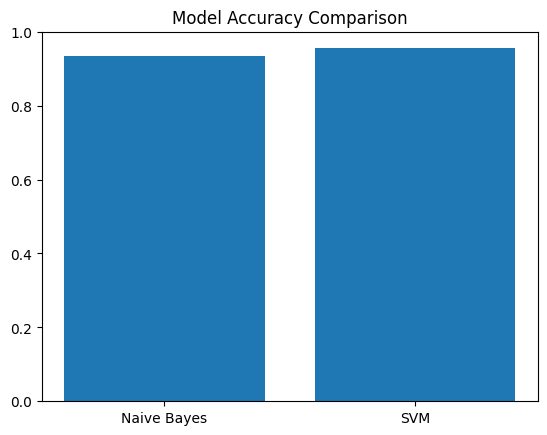

In [158]:
plt.bar(results['Model'], results['Accuracy'])
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()


In [159]:
feature_names = tfidf.get_feature_names_out()

for i, class_label in enumerate(le.classes_):
    top_indices = svm.coef_[i].argsort()[-20:]
    print(f"\nTop words for class {class_label}:")
    print([feature_names[j] for j in top_indices])


Top words for class Books:
['run', 'photograph', 'lifestyle', 'transportation', 'training', 'action', 'plating', 'polish', 'family', 'book', 'film', 'museum', 'climbing', 'sketch', 'oxford', 'marathon', 'cue', 'society', 'author', 'fishing']

Top words for class Clothing & Accessories:
['jacket', 'winter', 'blouse', 'handkerchief', 'dupatta', 'maternity', 'sweatshirt', 'raincoat', 'garter', 'unisex', 'headband', 'liner', 'swimwear', 'sock', 'girl', 'woman', 'boy', 'bra', 'sunglass', 'men']

Top words for class Electronics:
['optic', 'antenna', 'shredder', 'mbps', 'telephone', 'binocular', 'tripod', 'entertainment', 'reflector', 'charger', 'calculator', 'mount', 'camera', 'screen', 'lens', 'skylight', 'laptop', 'binoculars', 'trail', 'correction']

Top words for class Household:
['candy', 'latch', 'album', 'fragrance', 'curtain', 'charm', 'scrub', 'canopy', 'cauldron', 'plastic', 'wallet', 'chair', 'purifier', 'saw', 'pillow', 'extended', 'oven', 'door', 'bathrobe', 'vacuum']


#Zaključak

Može se zaključiti kako SVM postiže bolje performanse prilikom klasifikacije kategorije teksta. Taj zaključak je podržan rezultatima iz classification reporta. SVM postiže bolje f1 metrike za svaku od kategorija

Prednosti ovog pristupa su te što su klasifikatori jednostavni za trenirati i postižu vrlo dobre rezultate klasifikacije

Nedostatci su što je model i treniran i testiran na istom podatkovnom skupu. Model bih se trebao testirati dodatno na nekom drugom skupu podataka kako bih se dobio uvid. Također ovi modeli su tradicionalni modeli bazirani na čisto statističkim formulama. Zbog toga ukoliko dođe neki novi podatak kojeg model dosad nije vidio postoji velika šansa da se neće znati prilagoditi i precizno klasificirati categoriju. Zbog toga se češće za ovakve zadatke koriste modeli bazirani na transformer arhitekturi.

Za poboljšanje modela moglo bih se probati koristiti neki od reprezentativnih modela (BERT-based) ili generativnih (ChatGPT) za klasifikaciju, iako i jedna i druga metoda treba puno više računalnih resursa nego metode korištene u radu. Osim toga, modeli su se mogli trenirati pomocu grid searcha i stratified k-folda da se pronađe najbolji model i raspodijela trening i test skupa, iako bi to isto bilo više usklađeno s podacima na tom skupu podataka i trebalo bih se testirati model na nekom drugom skupu podataka kako bih se dobio iskreniji uvid u stvarne rezultate modela.

Iako se nisu testirali rezultati na običnom ne predobrađenom skupu podataka, predobradba pomaže jer modelu miće stvari koje mu nisu bitne za klasifikaciju kao što su html tagovi